In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import os, dotenv
project_path = os.path.dirname(dotenv.find_dotenv())

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
""
import pickle

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import arch

In [2]:
"""
Import Data.
"""

Ty=1
Tx=72

X_train=pd.read_csv('../data/processed/X_train_tx{}_ty{}.csv'.format(Tx, Ty))
Y_train=pd.read_csv('../data/processed/Y_train_tx{}_ty{}.csv'.format(Tx, Ty))
X_test=pd.read_csv('../data/processed/X_test_tx{}_ty{}.csv'.format(Tx, Ty))
Y_test=pd.read_csv('../data/processed/Y_test_tx{}_ty{}.csv'.format(Tx, Ty))

N_FEATURES=int(X_train.columns.values.size / Tx)


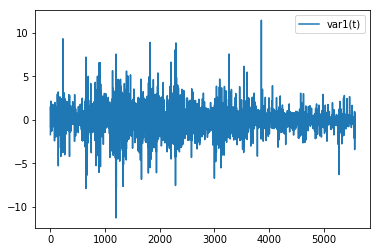

In [8]:

# # log returns
# lrets = np.log(df.close/df.close.shift(1)).dropna()
# lrets.plot()
# plt.show()

# percent change
pchange = Y_train
pchange.plot()
plt.show()



In [18]:
# For analysis
Y = pchange.values.ravel()
max_lag = 30
freq='H'
forecast_steps = 21

In [19]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

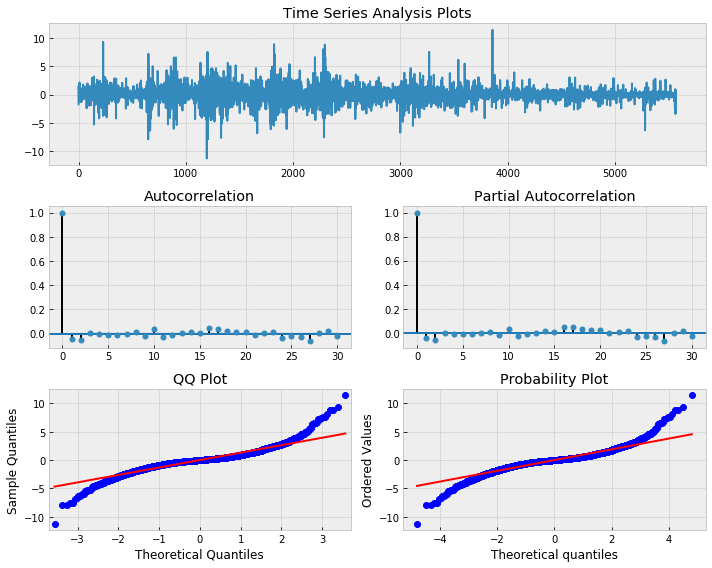

In [20]:
_ = tsplot(Y, lags=max_lag)

In [8]:
# Select best lag order for BTC returns using Autoregressive Model

ar_mdl = smt.AR(Y).fit(maxlag=max_lag, ic='aic', trend='nc')
ar_est_order = smt.AR(Y).select_order(maxlag=max_lag, ic='aic', trend='nc', freq=freq)

print('best estimated lag order = {}'.format(ar_est_order))
print(ar_mdl.summary())

/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


best estimated lag order = 30


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 9001
Model:                     ARMA(0, 3)   Log Likelihood              -14377.599
Method:                           mle   S.D. of innovations              1.195
Date:                Wed, 04 Jul 2018   AIC                          28763.197
Time:                        18:19:47   BIC                          28791.618
Sample:                    06-22-2017   HQIC                         28772.868
                         - 07-02-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ma.L1.close    -0.0468      0.011     -4.445      0.000      -0.068      -0.026
ma.L2.close    -0.0358      0.011     -3.368      0.001      -0.057      -0.015
ma.L3.close    -0.0026      0.011     -0.240    

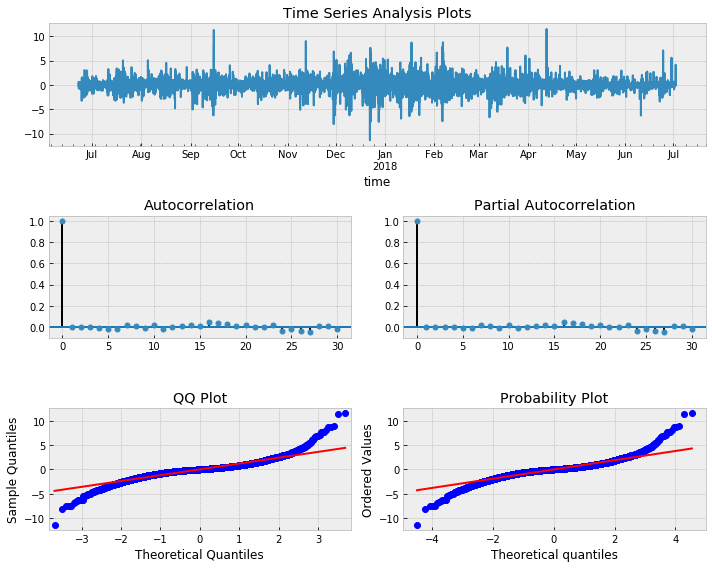

In [9]:
# Fit MA(3) to BTC returns
arma_mdl = smt.ARMA(Y, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc', freq=freq)

print(arma_mdl.summary())

# ARMA

In [11]:
# Fit ARMA model to BTC returns
def _get_best_arma(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    rng = range(5) # [0,1,2,3,4,5]
    for i in rng:
        for j in rng:
            try:
                tmp_mdl = smt.ARMA(TS, order=(i, j), freq='H').fit(method='mle', trend='nc', freq=freq)
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, j)
                    best_mdl = tmp_mdl
            except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

arma_aic, arma_order, arma_mdl = _get_best_arma(Y)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp

aic: 28755.76371 | order: (3, 3)


# ARIMA

In [7]:
def _get_best_arima(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j), freq=freq).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl


In [25]:
arima_aic, arima_order, arima_mdl = _get_best_arima(Y)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_st

aic: -54176.21664 | order: (4, 0, 2)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# Predict Volatility with ARIMA

In [108]:
# Create a ## hour forecast of BTC returns with 95%, 99% CI

f, err95, ci95 = arima_mdl.forecast(steps=forecast_steps) # 95% CI
_, err99, ci99 = arima_mdl.forecast(steps=forecast_steps, alpha=0.01) # 99% CI

idx = pd.date_range(Y.index[-1], periods=forecast_steps, freq=freq)
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2018-07-04 20:00:00,0.021454,-2.318146,-3.053301,2.361054,3.096209
2018-07-04 21:00:00,-0.022492,-2.364579,-3.100516,2.319595,3.055532
2018-07-04 22:00:00,-0.013895,-2.356989,-3.093243,2.329199,3.065452
2018-07-04 23:00:00,0.027849,-2.315816,-3.052249,2.371514,3.107947
2018-07-05 00:00:00,-0.015699,-2.359410,-3.095858,2.328012,3.064459


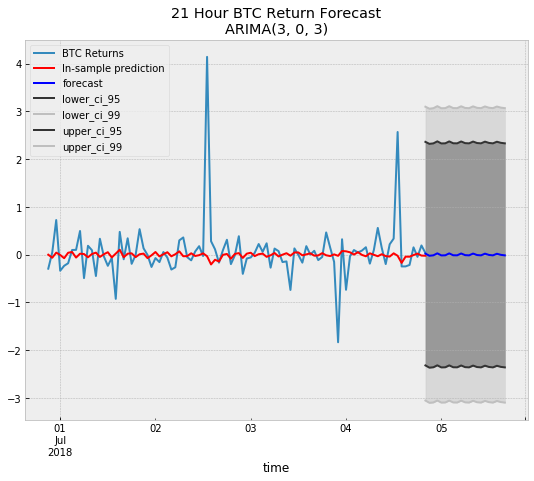

In [110]:
# Plot 21 hour forecast for BTC returns

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = Y.iloc[-96:].copy()
ts.plot(ax=ax, label='BTC Returns')
# in sample prediction
pred = arima_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Hour BTC Return Forecast\nARIMA{}'.format(forecast_steps, arima_order))
plt.legend(loc='best', fontsize=10)


# GARCH based on ARIMA

In [26]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = arima_order[0]
o_ = arima_order[1]
q_ = arima_order[2]

# Using student T distribution usually provides better fit
arch_mdl = arch.arch_model(arima_mdl.resid, p=p_, o=o_, q=q_, vol='GARCH', dist='StudentsT')
arch_res = arch_mdl.fit(update_freq=5, disp='off')
print(arch_res.summary())


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                29474.8
Distribution:      Standardized Student's t   AIC:                          -58931.6
Method:                  Maximum Likelihood   BIC:                          -58867.6
                                              No. Observations:                 9001
Date:                      Thu, Jul 05 2018   Df Residuals:                     8992
Time:                              17:10:13   Df Model:                            9
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [21]:
idx = pd.date_range(Y.index[-1], periods=forecast_steps, freq=freq)

In [113]:
# Create a 21 hour forecast of BTC returns
arch_f = arch_res.forecast(horizon=forecast_steps, start=Y.index[-1], method='simulation', simulations=1000) # 95% CI

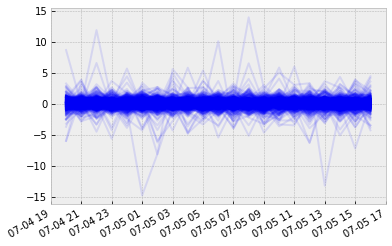

-1.006465706991328


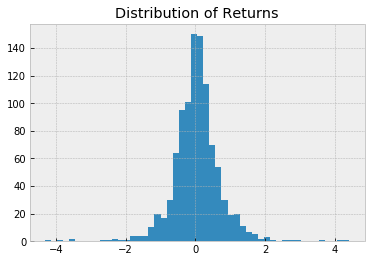

In [114]:

sims = arch_f.simulations
fig, ax = plt.subplots()
lines = plt.plot(idx, sims.values[-1,:,:].T, color='blue', alpha=0.10)
lines[0].set_label('Simulated paths')
fig.autofmt_xdate()
plt.show()

print(np.percentile(sims.values[-1,:,-1].T,5))
plt.hist(sims.values[-1, :,-1],bins=50)
plt.title('Distribution of Returns')
plt.show()

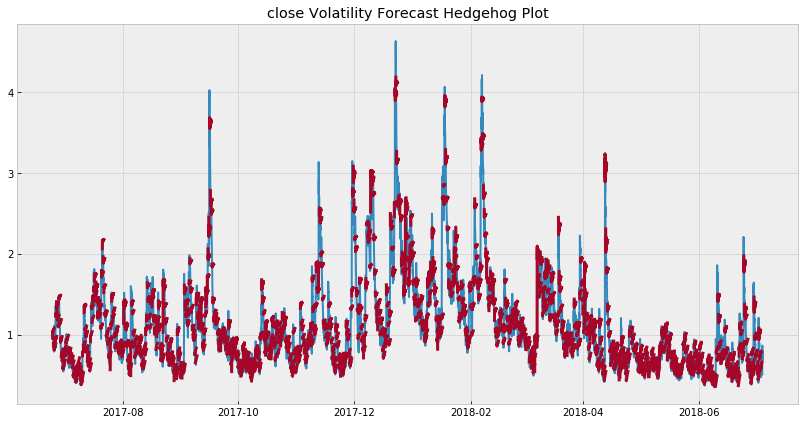

In [115]:
fig = arch_res.hedgehog_plot(horizon=forecast_steps)

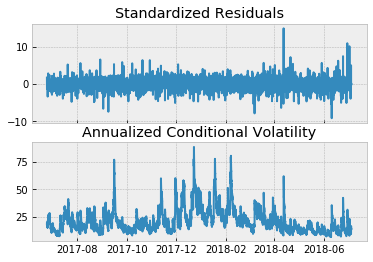

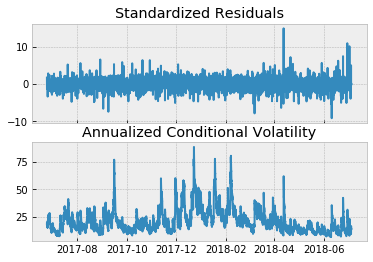

In [116]:
arch_res.plot(annualize='D', scale=365)

# From Medium
https://medium.com/auquan/time-series-analysis-for-finance-arch-garch-models-822f87f1d755

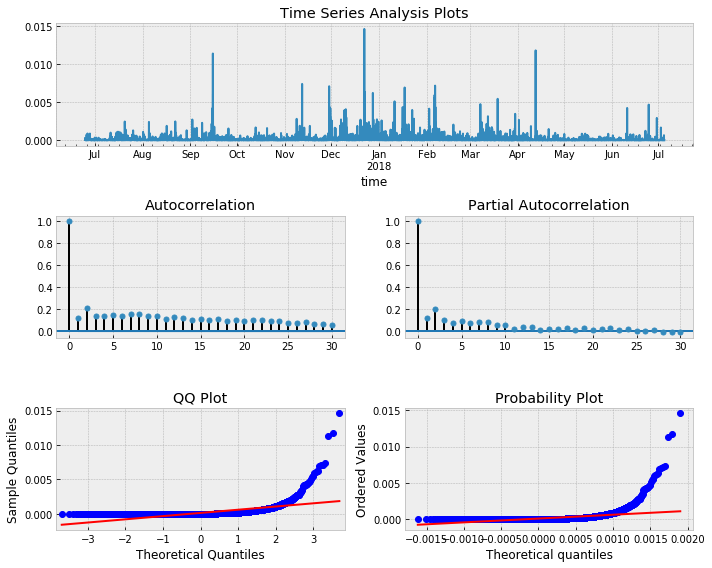

In [27]:
tsplot(arch_res.resid**2, lags=30)

In [30]:
Y_ = Y.iloc[-500:]
window = 300
foreLength = len(Y_) - window
signal = 0*Y[-foreLength:]
foreLength

200

In [31]:

def backtest(Y, foreLength, window, signal, order=''):
    for d in range(foreLength):

        # create a rolling window by selecting 
        # values between d+1 and d+T of S&P500 returns

        TS = Y[(1+d):(window+d)] 
        
        if order:
            best_order=order
            best_mdl=smt.ARIMA(TS, order=(best_order[0],best_order[1],best_order[2]), freq=freq).fit(
                        method='mle', trend='nc'
                    )
        else:
            # Find the best ARIMA fit 
            # set d = 0 since we've already taken log return of the series
            _, best_order, best_mdl = _get_best_arima(TS)
        
        
        #now that we have our ARIMA fit, we feed this to GARCH model
        p_ = best_order[0]
        o_ = best_order[1]
        q_ = best_order[2]
        
        if p_ == o_ == 0:
            p_ = 1
        
        am = arch.arch_model(best_mdl.resid, p=p_, o=o_, q=q_, dist='StudentsT')
        res = am.fit(update_freq=5, disp='off')

        # Generate a forecast of next day return using our fitted model
        out = res.forecast(horizon=1, start=None, align='origin')

        #Set trading signal equal to the sign of forecasted return
        # Buy if we expect positive returns, sell if negative

        signal.iloc[d] = np.sign(out.mean['h.1'].iloc[-1])
    return signal

In [ ]:
signal = backtest(Y_, foreLength, window, signal)

/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmode

aic: -2069.25252 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWar

aic: -2079.86359 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/User

aic: -2079.93194 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:608

aic: -2080.04541 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to con

aic: -2080.04707 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp

aic: -2080.05691 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-d

aic: -2079.92884 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to con

aic: -2079.98973 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp

aic: -2079.85222 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-

aic: -2079.29518 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/pyth

aic: -2078.25645 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/User

aic: -2075.02611 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:608: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:609: RuntimeWarning: overflow encountered in exp
  (1+np.exp

aic: -2083.24738 | order: (3, 0, 2)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-package

aic: -2081.04039 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-n

aic: -2082.62956 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: -2097.24968 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: -2100.85939 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/pyth

aic: -2101.37970 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/pyth

aic: -2101.39911 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


aic: -2101.48874 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opti

aic: -2101.53915 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


aic: -2101.45136 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params avai

aic: -2101.32626 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_

aic: -2101.21990 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/User

aic: -2101.57977 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWar

aic: -2101.58911 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:608

aic: -2100.57317 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/g

aic: -2099.31452 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:606: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/tsa/tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/pyth

aic: -2099.10082 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params avai

aic: -2099.10875 | order: (0, 0, 1)


/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/daniel_stevenson/anaconda3/envs/go-mint-datasci-challenge/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


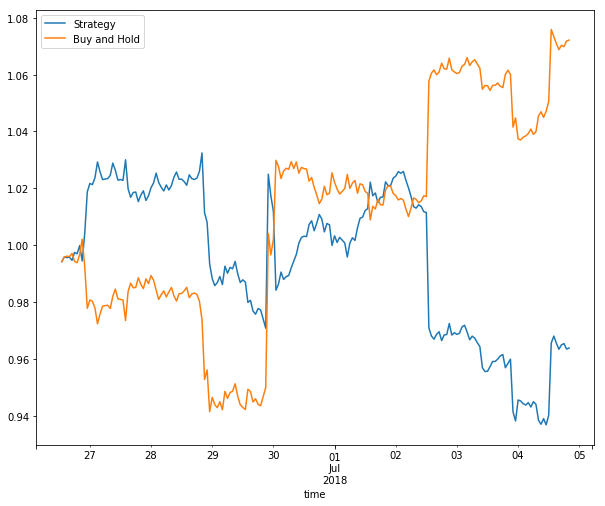

In [21]:
returns = pd.DataFrame(index = signal.index, 
                       columns=['Buy and Hold', 'Strategy'])
returns['Buy and Hold'] = Y.iloc[-foreLength:]
returns['Strategy'] = signal*returns['Buy and Hold']

eqCurves = pd.DataFrame(index = signal.index, 
                       columns=['Buy and Hold', 'Strategy'])
eqCurves['Buy and Hold']=returns['Buy and Hold'].cumsum()+1
eqCurves['Strategy'] = returns['Strategy'].cumsum()+1

eqCurves['Strategy'].plot(figsize=(10,8))
eqCurves['Buy and Hold'].plot()
plt.legend()
plt.show()

# From Arch website

In [7]:
from arch.univariate import ARX
ar = ARX(Y, lags = 30)
# print(ar.fit().summary())

In [8]:
from arch.univariate import ARCH, GARCH
ar.volatility = GARCH(p=3, o=0, q=3)
res = ar.fit(update_freq=0, disp='off')
# print(res.summary())

In [9]:
from arch.univariate import StudentsT
ar.distribution = StudentsT()
res = ar.fit(update_freq=0, disp='off')
print(res.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                        close   R-squared:                       0.012
Mean Model:                              AR   Adj. R-squared:                  0.008
Vol Model:                            GARCH   Log-Likelihood:               -11739.7
Distribution:      Standardized Student's t   AIC:                           23557.5
Method:                  Maximum Likelihood   BIC:                           23834.5
                                              No. Observations:                 8971
Date:                      Thu, Jul 05 2018   Df Residuals:                     8932
Time:                              16:36:48   Df Model:                           39
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

In [10]:
arf = ar.forecast(horizon=forecast_steps, start=Y.index[-1], parameters=res.params, method='simulation')


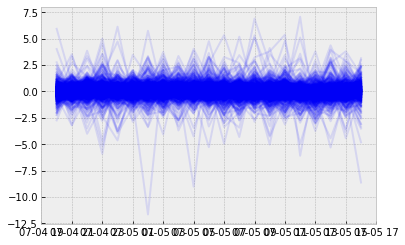

In [126]:
plt.plot(idx, arf.simulations.values[-1].T, color='blue', alpha=0.1)
plt.show()

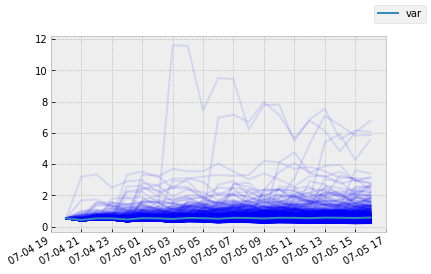

In [129]:
plt.style.use('bmh')
fig, ax = plt.subplots()
plt.plot(idx, arf.simulations.variances[-1,::].T, color='blue', alpha=0.1, label='simulated var')
plt.plot(idx, arf.variance.iloc[-1], label='expected var')
fig.autofmt_xdate()
fig.legend()
plt.show()

In [81]:
# arp = ar.simulate(params=res.params, nobs=res.nobs)
# arp[['data', 'errors']].plot(alpha=0.3)

['seaborn-darkgrid',
 'classic',
 'seaborn-talk',
 '_classic_test',
 'Solarize_Light2',
 'seaborn-notebook',
 'seaborn-deep',
 'fivethirtyeight',
 'seaborn-dark-palette',
 'grayscale',
 'seaborn-ticks',
 'seaborn-colorblind',
 'seaborn-bright',
 'dark_background',
 'seaborn-paper',
 'ggplot',
 'bmh',
 'fast',
 'seaborn-poster',
 'seaborn-pastel',
 'tableau-colorblind10',
 'seaborn',
 'seaborn-whitegrid',
 'seaborn-dark',
 'seaborn-muted',
 'seaborn-white']